In [1]:
# LogitLens_Analysis — Preamble

import os, sys, json, glob, math, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Find repo root and make it importable
CWD = Path.cwd()
REPO_ROOT = CWD
if not (REPO_ROOT / "logit_lens").exists():
    # if you started Jupyter in a subfolder, fall back to your repo path
    REPO_ROOT = Path.home() / "technion_transformers_project"
sys.path.insert(0, str(REPO_ROOT))

# Figure output dir
FIG_DIR = REPO_ROOT / "artifacts" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    plt.close()
    print(f"[figure] {path.relative_to(REPO_ROOT)}")


In [2]:
import yaml

CFG_PATH = REPO_ROOT / "logit_lens" / "configs" / "logit_lens.yaml"
with open(CFG_PATH, "r") as f:
    cfg = yaml.safe_load(f)

print("compute.device:", cfg.get("compute", {}).get("device", "cpu"))
print("model_dir (raw):", cfg["paths"]["model_dir"])
print("data_dir  (raw):", cfg["paths"]["data_dir"])
print("out_dir        :", cfg["paths"]["out_dir"])



compute.device: cpu
model_dir (raw): ./model
data_dir  (raw): ./data/NQ10k
out_dir        : ./logit_lens/results


In [3]:
paths = {
    "exp2_candidates": REPO_ROOT / "artifacts" / "exp2" / "exp2_candidates.csv",
    "exp3_summary_all": REPO_ROOT / "artifacts" / "exp3" / "exp3_summary_all_layers.csv",
    "exp3_top_neurons": REPO_ROOT / "artifacts" / "exp3" / "exp3_top_neurons.csv",
    "exp3_topdocs": REPO_ROOT / "artifacts" / "exp3" / "exp3_top_neurons_topdocs.csv",
}

for name, p in paths.items():
    print(f"{name:>18}: {'OK' if p.exists() else 'MISSING'}  -> {p}")

# quick peek
if paths["exp2_candidates"].exists():
    df2 = pd.read_csv(paths["exp2_candidates"])
    print("exp2_candidates rows:", len(df2))
    display(df2.head(5))

if paths["exp3_summary_all"].exists():
    df3 = pd.read_csv(paths["exp3_summary_all"])
    print("exp3_summary_all rows:", len(df3), "layers:", sorted(df3['layer'].unique().tolist()))
    display(df3.head(3))


   exp2_candidates: OK  -> /home/itaysegev/technion_transformers_project/artifacts/exp2/exp2_candidates.csv
  exp3_summary_all: OK  -> /home/itaysegev/technion_transformers_project/artifacts/exp3/exp3_summary_all_layers.csv
  exp3_top_neurons: OK  -> /home/itaysegev/technion_transformers_project/artifacts/exp3/exp3_top_neurons.csv
      exp3_topdocs: OK  -> /home/itaysegev/technion_transformers_project/artifacts/exp3/exp3_top_neurons_topdocs.csv
exp2_candidates rows: 343


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift,rank_score
0,23,1641,sports,0.819835,0.190476,0.011,17.316017,0.780795
1,23,827,sports,0.604746,0.142857,0.013,10.989011,0.431961
2,23,3236,sports,0.625963,0.095238,0.013,7.326007,0.298078
3,23,1936,sports,0.603558,0.047619,0.010,4.761905,0.136861
4,23,3312,science,0.843232,0.250000,0.010,25.000000,1.054040


exp3_summary_all rows: 343 layers: [18, 19, 20, 21, 22, 23]


,layer,neuron_id,n_queries,active_count,active_rate,unique_docs,top_doc_token_id,top_doc_freq,top_doc_frac,doc_entropy,layer_dir,file
0,18,15,1000,52,0.052,50,40945,52,0.02,3.912023,L18,neuron_000015_exp3_summary.csv
1,18,33,1000,40,0.040,50,40767,40,0.02,3.912023,L18,neuron_000033_exp3_summary.csv
2,18,46,1000,95,0.095,50,35024,95,0.02,3.912023,L18,neuron_000046_exp3_summary.csv


In [4]:
def make_abs(p):
    p = Path(p)
    if not p.is_absolute():
        p = REPO_ROOT / p
    return str(p.resolve())

model_dir_abs = make_abs(cfg["paths"]["model_dir"])
data_dir_abs  = make_abs(cfg["paths"]["data_dir"])
print("model_dir_abs:", model_dir_abs)
print("data_dir_abs :", data_dir_abs)

# sanity
assert Path(model_dir_abs).exists(), f"missing model_dir: {model_dir_abs}"
assert Path(data_dir_abs).exists(),  f"missing data_dir:  {data_dir_abs}"
print("[ok] absolute paths exist")


model_dir_abs: /home/itaysegev/technion_transformers_project/model
data_dir_abs : /home/itaysegev/236004-HW1-GPT/GenIR-Data/NQ10k
[ok] absolute paths exist


In [5]:
# If you want titles in tables/plots, keep True; set False to skip quickly
LOAD_TITLES = True

doc_index = {}
if LOAD_TITLES:
    try:
        os.environ["HF_HUB_OFFLINE"] = "1"  # force local loading
        from logit_lens.utils.doc_lookup import build_doc_index
        doc_index = build_doc_index(model_dir_abs, data_dir_abs)
        print("doc_index size:", len(doc_index))
        # peek a few
        i = 0
        for tid, meta in doc_index.items():
            print(tid, "|", meta.get("token_str"), "|", (meta.get("title") or "")[:60])
            i += 1
            if i >= 3: break
    except Exception as e:
        print("doc_index load failed:", e, "\n→ You can set LOAD_TITLES=False and continue.")
else:
    print("Skipping doc_index (titles).")


doc_index size: 10000
32100 | @DOC_ID_-2081335883615568321@ | 
32101 | @DOC_ID_-3952149172515325408@ | 
32102 | @DOC_ID_3180949643664273199@ | 


In [6]:
def attach_titles(df: pd.DataFrame, id_col="doc_token_id"):
    """
    Add a 'title' column to df if missing, using doc_index (if available).
    """
    if "title" in df.columns:
        return df
    if not doc_index:
        df["title"] = ""
        return df
    def _title(tid):
        meta = doc_index.get(int(tid), {})
        return meta.get("title", "")
    try:
        df["title"] = df[id_col].apply(_title)
    except Exception:
        df["title"] = ""
    return df


In [7]:
# test 1: paths
assert Path(model_dir_abs).exists() and Path(data_dir_abs).exists()
print("[ok] paths exist")

# test 2: exp3 summary has expected columns (if present)
required_cols = {"layer","neuron_id","n_queries","active_count","active_rate",
                 "unique_docs","top_doc_token_id","top_doc_freq","top_doc_frac","doc_entropy"}
if (REPO_ROOT / "artifacts/exp3/exp3_summary_all_layers.csv").exists():
    cols = set(pd.read_csv(REPO_ROOT / "artifacts/exp3/exp3_summary_all_layers.csv", nrows=0).columns)
    missing = required_cols - cols
    print("[ok] exp3 summary columns" if not missing else f"[warn] missing cols: {missing}")

# test 3: figure write
p = FIG_DIR / "._write_test.png"
plt.figure(); plt.plot([0,1],[0,1]); savefig(p); p.unlink(missing_ok=True)
print("[ok] figure write test")


[ok] paths exist
[ok] exp3 summary columns
[figure] artifacts/figures/._write_test.png
[ok] figure write test


In [8]:
from pathlib import Path

EXP2_DIR = REPO_ROOT / "artifacts" / "exp2"

def load_exp2_tables(layer: int):
    spec_path = EXP2_DIR / f"neuron_specialization_L{layer}.csv"
    top_path  = EXP2_DIR / f"top_specialists_L{layer}.csv"
    df_spec = pd.read_csv(spec_path) if spec_path.exists() else pd.DataFrame()
    df_top  = pd.read_csv(top_path)  if top_path.exists()  else pd.DataFrame()
    return df_spec, df_top

# discover layers by what's present in artifacts/exp2/
layers_found = sorted({
    int(p.stem.split("L")[-1])
    for p in EXP2_DIR.glob("neuron_specialization_L*.csv")
})
print("Exp-2 layers found:", layers_found)

# quick peek first layer (if any)
if layers_found:
    df_spec0, df_top0 = load_exp2_tables(layers_found[0])
    print(f"L{layers_found[0]} spec rows:", len(df_spec0), "| top_specialists rows:", len(df_top0))
    display(df_spec0.head(3))
    display(df_top0.head(3))


Exp-2 layers found: [18, 19, 20, 21, 22, 23]
L18 spec rows: 4096 | top_specialists rows: 200


,neuron_id,layer,n_queries,fired_count,activity_rate,entropy,spec_score,top_category,top_cat_rate,top_cat_lift,...,cat_other_count,cat_entertainment_count,cat_definition_count,cat_history_count,cat_sports_count,cat_dates_numbers_count,cat_biography_count,cat_geography_count,cat_science_count,cat_author_count
0,0,18,64,5,0.078125,0.612455,0.734014,dates_numbers,0.250000,3.200000,...,4,0,0,0,0,1,0,0,0,0
1,1,18,64,0,0.000000,0.000000,0.000000,other,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,2,18,64,2,0.031250,0.266384,0.884311,definition,0.333333,10.666667,...,1,0,1,0,0,0,0,0,0,0


,neuron_id,layer,spec_score,top_category,top_cat_rate,activity_rate,top_cat_lift
0,106,18,1.0,sports,1.0,0.015625,64.0
1,2080,18,1.0,author,1.0,0.015625,64.0
2,1404,18,1.0,sports,1.0,0.015625,64.0


In [9]:
def plot_spec_hist(layer: int):
    df_spec, _ = load_exp2_tables(layer)
    if df_spec.empty or "spec_score" not in df_spec:
        print(f"[skip] L{layer}: spec table missing or no spec_score")
        return
    df_spec["spec_score"].plot(kind="hist", bins=30, title=f"Exp-2: spec_score (L{layer})")
    plt.xlabel("spec_score")
    out = FIG_DIR / f"exp2_L{layer}_spec_hist.png"
    savefig(out)

for L in layers_found:
    plot_spec_hist(L)


[figure] artifacts/figures/exp2_L18_spec_hist.png
[figure] artifacts/figures/exp2_L19_spec_hist.png
[figure] artifacts/figures/exp2_L20_spec_hist.png
[figure] artifacts/figures/exp2_L21_spec_hist.png
[figure] artifacts/figures/exp2_L22_spec_hist.png
[figure] artifacts/figures/exp2_L23_spec_hist.png


In [10]:
def plot_category_bar(layer: int):
    _, df_top = load_exp2_tables(layer)
    if df_top.empty or "top_category" not in df_top:
        print(f"[skip] L{layer}: top_specialists table missing or no top_category")
        return
    (df_top.groupby("top_category")["neuron_id"].count()
          .sort_values(ascending=False)).plot(kind="bar", title=f"Exp-2: top specialists by category (L{layer})")
    plt.ylabel("count")
    out = FIG_DIR / f"exp2_L{layer}_category_bar.png"
    savefig(out)

for L in layers_found:
    plot_category_bar(L)


[figure] artifacts/figures/exp2_L18_category_bar.png
[figure] artifacts/figures/exp2_L19_category_bar.png
[figure] artifacts/figures/exp2_L20_category_bar.png
[figure] artifacts/figures/exp2_L21_category_bar.png
[figure] artifacts/figures/exp2_L22_category_bar.png
[figure] artifacts/figures/exp2_L23_category_bar.png


In [12]:
def plot_spec_vs_activity(layer: int):
    df_spec, df_top = load_exp2_tables(layer)
    if df_spec.empty:
        print(f"[skip] L{layer}: no spec table")
        return

    df = df_spec.copy()

    # Try to merge categories if available; otherwise fall back to "unknown"
    if (
        "neuron_id" in df and
        not df_top.empty and
        "neuron_id" in df_top.columns and
        "top_category" in df_top.columns
    ):
        df = df.merge(
            df_top[["neuron_id", "top_category"]].drop_duplicates(),
            on="neuron_id",
            how="left"
        )

    if "top_category" not in df.columns:
        df["top_category"] = "unknown"

    if "spec_score" not in df.columns or "activity_rate" not in df.columns:
        print(f"[skip] L{layer}: missing spec_score/activity_rate")
        return

    cats = df["top_category"].fillna("unknown")
    uniq = sorted(cats.unique().tolist())
    color_map = {c: i for i, c in enumerate(uniq)}
    colors = cats.map(color_map).values

    plt.figure()
    plt.scatter(df["activity_rate"], df["spec_score"], c=colors, alpha=0.35)
    plt.xlabel("activity_rate")
    plt.ylabel("spec_score")
    plt.title(f"Exp-2: spec vs activity (L{layer})")
    out = FIG_DIR / f"exp2_L{layer}_spec_vs_activity.png"
    savefig(out)

for L in layers_found:
    plot_spec_vs_activity(L)


[figure] artifacts/figures/exp2_L18_spec_vs_activity.png
[figure] artifacts/figures/exp2_L19_spec_vs_activity.png
[figure] artifacts/figures/exp2_L20_spec_vs_activity.png
[figure] artifacts/figures/exp2_L21_spec_vs_activity.png
[figure] artifacts/figures/exp2_L22_spec_vs_activity.png
[figure] artifacts/figures/exp2_L23_spec_vs_activity.png


In [15]:
consol_rows = []
for L in layers_found:
    _, df_top = load_exp2_tables(L)
    if df_top.empty:
        print(f"[skip] L{L}: no top_specialists")
        continue

    # Sort preference: rank_score, else spec_score, else first numeric column
    sort_cols = [c for c in ["rank_score", "spec_score"] if c in df_top.columns]
    if not sort_cols:
        num_cols = df_top.select_dtypes(include=["number"]).columns.tolist()
        sort_cols = num_cols[:1] if num_cols else df_top.columns[:1].tolist()

    dfk = df_top.sort_values(sort_cols, ascending=False).head(10).copy()

    # Ensure there is a 'layer' column with the correct value, without duplicating
    if "layer" not in dfk.columns:
        dfk.insert(0, "layer", L)
    else:
        # overwrite with the current layer to be safe/consistent
        dfk["layer"] = L

    consol_rows.append(dfk)

    # Display only columns that actually exist
    display_cols = [c for c in [
        "layer","neuron_id","top_category","spec_score",
        "top_cat_rate","activity_rate","top_cat_lift","rank_score"
    ] if c in dfk.columns]

    print(f"\nL{L} — top specialists:")
    display(dfk[display_cols].head(10))

if consol_rows:
    df_all = pd.concat(consol_rows, ignore_index=True)
    out_csv = REPO_ROOT / "artifacts" / "exp2" / "top_specialists_all_layers.csv"
    df_all.to_csv(out_csv, index=False)
    print("[OK] wrote", out_csv.relative_to(REPO_ROOT), "rows:", len(df_all))



L18 — top specialists:


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift
0,18,106,sports,1.0,1.0,0.015625,64.0
29,18,2397,sports,1.0,1.0,0.015625,64.0
21,18,2805,sports,1.0,1.0,0.015625,64.0
22,18,2738,sports,1.0,1.0,0.015625,64.0
23,18,2480,sports,1.0,1.0,0.015625,64.0
24,18,2322,sports,1.0,1.0,0.015625,64.0
25,18,4011,author,1.0,1.0,0.015625,64.0
26,18,1734,author,1.0,1.0,0.015625,64.0
28,18,1132,author,1.0,1.0,0.015625,64.0
30,18,1983,author,1.0,1.0,0.015625,64.0



L19 — top specialists:


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift
126,19,3295,science,0.827636,0.083333,0.009,9.259259
27,19,80,science,0.757924,0.166667,0.015,11.111111
116,19,2274,sports,0.744842,0.095238,0.005,19.047619
139,19,42,author,0.714108,0.093750,0.006,15.625000
30,19,4055,science,0.713390,0.166667,0.006,27.777778
21,19,1898,author,0.706575,0.187500,0.010,18.750000
188,19,129,author,0.652740,0.093750,0.007,13.392857
177,19,3753,sports,0.651705,0.095238,0.009,10.582011
39,19,1302,science,0.645107,0.166667,0.016,10.416667
192,19,765,sports,0.640674,0.095238,0.007,13.605442



L20 — top specialists:


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift
69,20,1267,sports,0.962832,0.095238,0.003,31.746032
10,20,192,science,0.906818,0.166667,0.008,20.833333
114,20,2393,science,0.869329,0.083333,0.006,13.888889
98,20,2983,history,0.828227,0.094340,0.014,6.738544
17,20,3123,science,0.778992,0.166667,0.011,15.151515
24,20,2136,science,0.750448,0.166667,0.011,15.151515
45,20,2035,sports,0.727904,0.142857,0.009,15.873016
27,20,2987,science,0.722606,0.166667,0.017,9.803922
1,20,2617,science,0.703794,0.333333,0.034,9.803922
51,20,130,sports,0.700745,0.142857,0.011,12.987013



L21 — top specialists:


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift
100,21,3293,science,0.930217,0.083333,0.003,27.777778
109,21,1767,science,0.906818,0.083333,0.004,20.833333
3,21,97,science,0.886807,0.166667,0.010,16.666667
110,21,658,definition,0.815913,0.092105,0.017,5.417957
0,21,3543,science,0.761462,0.250000,0.018,13.888889
185,21,1113,science,0.751294,0.083333,0.005,16.666667
30,21,1349,geography,0.733818,0.152174,0.018,8.454106
139,21,579,sports,0.714378,0.095238,0.007,13.605442
20,21,2483,geography,0.684105,0.173913,0.023,7.561437
37,21,3295,science,0.636751,0.166667,0.019,8.771930



L22 — top specialists:


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift
72,22,1751,science,1.000000,0.083333,0.001,83.333333
189,22,372,author,0.948470,0.062500,0.003,20.833333
58,22,3648,history,0.936315,0.094340,0.007,13.477089
60,22,2270,sports,0.915132,0.095238,0.005,19.047619
65,22,268,sports,0.896453,0.095238,0.006,15.873016
94,22,3035,science,0.886807,0.083333,0.005,16.666667
71,22,3096,sports,0.879988,0.095238,0.007,13.605442
108,22,100,science,0.853862,0.083333,0.007,11.904762
15,22,3774,science,0.816464,0.166667,0.007,23.809524
32,22,2491,sports,0.774726,0.142857,0.011,12.987013



L23 — top specialists:


,layer,neuron_id,top_category,spec_score,top_cat_rate,activity_rate,top_cat_lift
67,23,2212,science,0.958729,0.083333,0.002,41.666667
191,23,2892,biography,0.947248,0.060606,0.003,20.202020
170,23,564,geography,0.916728,0.065217,0.005,13.043478
183,23,1778,geography,0.889948,0.065217,0.006,10.869565
41,23,365,geography,0.889948,0.108696,0.010,10.869565
126,23,187,history,0.879251,0.075472,0.008,9.433962
58,23,465,sports,0.865289,0.095238,0.008,11.904762
1,23,3312,science,0.843232,0.250000,0.010,25.000000
110,23,3397,science,0.840051,0.083333,0.008,10.416667
117,23,3629,science,0.827636,0.083333,0.009,9.259259


[OK] wrote artifacts/exp2/top_specialists_all_layers.csv rows: 60


In [16]:
figs = sorted(str(p.relative_to(REPO_ROOT)) for p in FIG_DIR.glob("exp2_*.png"))
print("Generated Exp-2 figures:", len(figs))
for s in figs[:24]:
    print(" -", s)


Generated Exp-2 figures: 18
 - artifacts/figures/exp2_L18_category_bar.png
 - artifacts/figures/exp2_L18_spec_hist.png
 - artifacts/figures/exp2_L18_spec_vs_activity.png
 - artifacts/figures/exp2_L19_category_bar.png
 - artifacts/figures/exp2_L19_spec_hist.png
 - artifacts/figures/exp2_L19_spec_vs_activity.png
 - artifacts/figures/exp2_L20_category_bar.png
 - artifacts/figures/exp2_L20_spec_hist.png
 - artifacts/figures/exp2_L20_spec_vs_activity.png
 - artifacts/figures/exp2_L21_category_bar.png
 - artifacts/figures/exp2_L21_spec_hist.png
 - artifacts/figures/exp2_L21_spec_vs_activity.png
 - artifacts/figures/exp2_L22_category_bar.png
 - artifacts/figures/exp2_L22_spec_hist.png
 - artifacts/figures/exp2_L22_spec_vs_activity.png
 - artifacts/figures/exp2_L23_category_bar.png
 - artifacts/figures/exp2_L23_spec_hist.png
 - artifacts/figures/exp2_L23_spec_vs_activity.png


In [17]:
from pathlib import Path

EXP3_DIR = REPO_ROOT / "artifacts" / "exp3"

# curated summaries
EXP3_SUMMARY = EXP3_DIR / "exp3_summary_all_layers.csv"
EXP3_TOPN    = EXP3_DIR / "exp3_top_neurons.csv"
EXP3_TOPDOCS = EXP3_DIR / "exp3_top_neurons_topdocs.csv"

df3 = pd.read_csv(EXP3_SUMMARY) if EXP3_SUMMARY.exists() else pd.DataFrame()
print("Exp-3 summary rows:", len(df3))
print("Layers in Exp-3:", sorted(df3["layer"].unique().tolist()) if not df3.empty else "[]")
display(df3.head(3))

# helper: path to per-neuron promotions (raw)
def prom_path(layer: int, neuron_id: int) -> Path:
    return REPO_ROOT / f"logit_lens/results/exp3/L{layer}/neuron_{int(neuron_id):06d}_doc_promotions.csv"

def load_promotions(layer: int, neuron_id: int, topk: int = 10) -> pd.DataFrame:
    p = prom_path(layer, neuron_id)
    if not p.exists():
        return pd.DataFrame()
    dfp = pd.read_csv(p)
    dfp = dfp.head(topk).copy()
    # ensure title present
    dfp = attach_titles(dfp, id_col="doc_token_id")
    return dfp


Exp-3 summary rows: 343
Layers in Exp-3: [18, 19, 20, 21, 22, 23]


,layer,neuron_id,n_queries,active_count,active_rate,unique_docs,top_doc_token_id,top_doc_freq,top_doc_frac,doc_entropy,layer_dir,file
0,18,15,1000,52,0.052,50,40945,52,0.02,3.912023,L18,neuron_000015_exp3_summary.csv
1,18,33,1000,40,0.040,50,40767,40,0.02,3.912023,L18,neuron_000033_exp3_summary.csv
2,18,46,1000,95,0.095,50,35024,95,0.02,3.912023,L18,neuron_000046_exp3_summary.csv


In [18]:
def plot_topdocfrac_hist(layer: int):
    dfl = df3[df3["layer"] == layer]
    if dfl.empty:
        print(f"[skip] L{layer}: no summary rows")
        return
    dfl["top_doc_frac"].plot(kind="hist", bins=30, title=f"Exp-3: top_doc_frac (L{layer})")
    plt.xlabel("top_doc_frac")
    out = FIG_DIR / f"exp3_L{layer}_top_doc_frac_hist.png"
    savefig(out)

for L in sorted(df3["layer"].unique()):
    plot_topdocfrac_hist(int(L))


[figure] artifacts/figures/exp3_L18_top_doc_frac_hist.png
[figure] artifacts/figures/exp3_L19_top_doc_frac_hist.png
[figure] artifacts/figures/exp3_L20_top_doc_frac_hist.png
[figure] artifacts/figures/exp3_L21_top_doc_frac_hist.png
[figure] artifacts/figures/exp3_L22_top_doc_frac_hist.png
[figure] artifacts/figures/exp3_L23_top_doc_frac_hist.png


In [19]:
def plot_entropy_vs_active(layer: int):
    dfl = df3[df3["layer"] == layer]
    if dfl.empty:
        print(f"[skip] L{layer}: no summary rows")
        return
    plt.figure()
    plt.scatter(dfl["active_rate"], dfl["doc_entropy"], alpha=0.4)
    plt.xlabel("active_rate")
    plt.ylabel("doc_entropy")
    plt.title(f"Exp-3: entropy vs active_rate (L{layer})")
    out = FIG_DIR / f"exp3_L{layer}_entropy_vs_active.png"
    savefig(out)

for L in sorted(df3["layer"].unique()):
    plot_entropy_vs_active(int(L))


[figure] artifacts/figures/exp3_L18_entropy_vs_active.png
[figure] artifacts/figures/exp3_L19_entropy_vs_active.png
[figure] artifacts/figures/exp3_L20_entropy_vs_active.png
[figure] artifacts/figures/exp3_L21_entropy_vs_active.png
[figure] artifacts/figures/exp3_L22_entropy_vs_active.png
[figure] artifacts/figures/exp3_L23_entropy_vs_active.png


In [22]:
# choose a few top neurons per layer
df_topN = pd.read_csv(EXP3_TOPN) if EXP3_TOPN.exists() else pd.DataFrame()
print("Top-neurons table rows:", len(df_topN))
display(df_topN.head(5))

def _labels_from(dfp: pd.DataFrame):
    # prefer title; if empty/missing, fall back to doc_token_str; else doc_token_id
    if "title" in dfp.columns:
        lab = dfp["title"].astype(str)
        if "doc_token_str" in dfp.columns:
            lab = lab.mask(lab.str.len() == 0, dfp["doc_token_str"])
        else:
            lab = lab.mask(lab.str.len() == 0, dfp["doc_token_id"].astype(str))
        return lab.tolist()
    if "doc_token_str" in dfp.columns:
        return dfp["doc_token_str"].astype(str).tolist()
    return dfp["doc_token_id"].astype(str).tolist()

def plot_neuron_topdocs(layer: int, neuron_id: int, topk_docs: int = 10):
    dfp = load_promotions(layer, neuron_id, topk=topk_docs)
    if dfp.empty:
        print(f"[skip] L{layer} N{neuron_id}: no promotions file")
        return
    labels = _labels_from(dfp)
    plt.figure(figsize=(8,4))
    plt.bar(range(len(dfp)), dfp["freq"].values)
    plt.xticks(range(len(dfp)), labels, rotation=45, ha="right")
    plt.ylabel("freq in top-K")
    plt.title(f"L{layer} N{int(neuron_id)} — top promoted docs")
    out = FIG_DIR / f"exp3_L{layer}_N{int(neuron_id)}_topdocs.png"
    savefig(out)

# how many per layer to plot:
N_PER_LAYER = 5
for L in sorted(df3["layer"].unique()):
    sub = df_topN[df_topN["layer"] == L].sort_values("top_doc_frac", ascending=False).head(N_PER_LAYER)
    if sub.empty:
        print(f"[skip] L{L}: no top-neuron rows")
        continue
    for nid in sub["neuron_id"].tolist():
        plot_neuron_topdocs(int(L), int(nid), topk_docs=10)


Top-neurons table rows: 60


,layer,neuron_id,top_doc_token_id,top_doc_freq,top_doc_frac,doc_entropy
0,18,15,40945,52,0.02,3.912023
1,18,33,40767,40,0.02,3.912023
2,18,46,35024,95,0.02,3.912023
3,18,71,39361,83,0.02,3.912023
4,18,83,32121,91,0.02,3.912023


[figure] artifacts/figures/exp3_L18_N15_topdocs.png
[figure] artifacts/figures/exp3_L18_N33_topdocs.png
[figure] artifacts/figures/exp3_L18_N46_topdocs.png
[figure] artifacts/figures/exp3_L18_N71_topdocs.png
[figure] artifacts/figures/exp3_L18_N83_topdocs.png
[figure] artifacts/figures/exp3_L19_N80_topdocs.png
[figure] artifacts/figures/exp3_L19_N99_topdocs.png
[figure] artifacts/figures/exp3_L19_N465_topdocs.png
[figure] artifacts/figures/exp3_L19_N543_topdocs.png
[figure] artifacts/figures/exp3_L19_N649_topdocs.png
[figure] artifacts/figures/exp3_L20_N3_topdocs.png
[figure] artifacts/figures/exp3_L20_N33_topdocs.png
[figure] artifacts/figures/exp3_L20_N130_topdocs.png
[figure] artifacts/figures/exp3_L20_N684_topdocs.png
[figure] artifacts/figures/exp3_L20_N808_topdocs.png
[figure] artifacts/figures/exp3_L21_N42_topdocs.png
[figure] artifacts/figures/exp3_L21_N97_topdocs.png
[figure] artifacts/figures/exp3_L21_N250_topdocs.png
[figure] artifacts/figures/exp3_L21_N325_topdocs.png
[figu

In [23]:
figs3 = sorted(str(p.relative_to(REPO_ROOT)) for p in FIG_DIR.glob("exp3_*.png"))
print("Generated Exp-3 figures:", len(figs3))
for s in figs3[:24]:
    print(" -", s)


Generated Exp-3 figures: 42
 - artifacts/figures/exp3_L18_N15_topdocs.png
 - artifacts/figures/exp3_L18_N33_topdocs.png
 - artifacts/figures/exp3_L18_N46_topdocs.png
 - artifacts/figures/exp3_L18_N71_topdocs.png
 - artifacts/figures/exp3_L18_N83_topdocs.png
 - artifacts/figures/exp3_L18_entropy_vs_active.png
 - artifacts/figures/exp3_L18_top_doc_frac_hist.png
 - artifacts/figures/exp3_L19_N465_topdocs.png
 - artifacts/figures/exp3_L19_N543_topdocs.png
 - artifacts/figures/exp3_L19_N649_topdocs.png
 - artifacts/figures/exp3_L19_N80_topdocs.png
 - artifacts/figures/exp3_L19_N99_topdocs.png
 - artifacts/figures/exp3_L19_entropy_vs_active.png
 - artifacts/figures/exp3_L19_top_doc_frac_hist.png
 - artifacts/figures/exp3_L20_N130_topdocs.png
 - artifacts/figures/exp3_L20_N33_topdocs.png
 - artifacts/figures/exp3_L20_N3_topdocs.png
 - artifacts/figures/exp3_L20_N684_topdocs.png
 - artifacts/figures/exp3_L20_N808_topdocs.png
 - artifacts/figures/exp3_L20_entropy_vs_active.png
 - artifacts/figu

In [24]:
from pathlib import Path
import csv

EXP1_ROOT = REPO_ROOT / "logit_lens" / "results" / "exp1"

def find_exp1_summaries(layers=None):
    layers = layers or [18,19,20,21,22,23]
    files = []
    for L in layers:
        d = EXP1_ROOT / f"L{L}"
        if not d.exists(): 
            continue
        files += sorted(d.glob("neuron_*_summary.csv"))
    return files

def aggregate_exp1_summaries(layers=None):
    rows = []
    for f in find_exp1_summaries(layers):
        L = int(f.parent.name[1:])
        with open(f, newline="", encoding="utf-8") as fh:
            r = list(csv.reader(fh))
            if len(r) < 2: 
                continue
            header, vals = r[0], r[1]
            # Build a dict safely with known keys if present
            d = {"layer": L, "file": f.name}
            for k, v in zip(header, vals):
                # coerce numbers where possible
                try:
                    if "." in v or "e" in v.lower():
                        d[k] = float(v)
                    else:
                        d[k] = int(v)
                except Exception:
                    d[k] = v
            rows.append(d)
    return pd.DataFrame(rows)

df1 = aggregate_exp1_summaries()
print("Exp-1 summary rows:", len(df1))
display(df1.head(3))


Exp-1 summary rows: 24576


,layer,file,neuron_id,lens,n_queries,active_count,active_rate,a_j_mean_active,a_j_std_active,top1_mode_doc_token_id,top1_mode_frac,gt_n_with_label,hits@1,hits@5,hits@10,hits@20
0,18,neuron_000000_summary.csv,0,simple,8,0,0.000,0.000000,0.0,,0.0,0,0,0,0,0
1,18,neuron_000001_summary.csv,1,simple,8,0,0.000,0.000000,0.0,,0.0,0,0,0,0,0
2,18,neuron_000002_summary.csv,2,simple,8,1,0.125,24.933151,0.0,40115,1.0,0,0,0,0,0


In [25]:
def plot_exp1_active_hist(layer: int):
    dfl = df1[df1["layer"] == layer]
    if dfl.empty or "active_rate" not in dfl.columns:
        print(f"[skip] L{layer}: no active_rate")
        return
    dfl["active_rate"].plot(kind="hist", bins=30, title=f"Exp-1: active_rate (L{layer})")
    plt.xlabel("active_rate")
    out = FIG_DIR / f"exp1_L{layer}_active_rate_hist.png"
    savefig(out)

for L in sorted(df1["layer"].unique()):
    plot_exp1_active_hist(int(L))


[figure] artifacts/figures/exp1_L18_active_rate_hist.png
[figure] artifacts/figures/exp1_L19_active_rate_hist.png
[figure] artifacts/figures/exp1_L20_active_rate_hist.png
[figure] artifacts/figures/exp1_L21_active_rate_hist.png
[figure] artifacts/figures/exp1_L22_active_rate_hist.png
[figure] artifacts/figures/exp1_L23_active_rate_hist.png


In [26]:
def plot_exp1_hitk_cdfs(layer: int):
    dfl = df1[df1["layer"] == layer]
    cols = [c for c in ["hit@1","hit@5","hit@10","hit@20"] if c in dfl.columns]
    if dfl.empty or not cols:
        print(f"[skip] L{layer}: no hit@k columns")
        return
    plt.figure()
    for c in cols:
        # If your summary stores counts/proportions differently, adjust here.
        # We'll just plot the distribution of per-neuron values if present.
        xs = np.sort(dfl[c].values)
        ys = np.linspace(0, 1, len(xs), endpoint=True)
        plt.plot(xs, ys, label=c)
    plt.xlabel("value"); plt.ylabel("CDF")
    plt.title(f"Exp-1: CDFs of hit@k (L{layer})")
    plt.legend()
    out = FIG_DIR / f"exp1_L{layer}_hitk_cdf.png"
    savefig(out)

for L in sorted(df1["layer"].unique()):
    plot_exp1_hitk_cdfs(int(L))


[skip] L18: no hit@k columns
[skip] L19: no hit@k columns
[skip] L20: no hit@k columns
[skip] L21: no hit@k columns
[skip] L22: no hit@k columns
[skip] L23: no hit@k columns


In [27]:
# Grab one neuron from Exp-2 (top of the list) and show its Exp-1 perquery rows
cands = paths["exp2_candidates"]
if cands.exists():
    dfcand = pd.read_csv(cands)
    example = dfcand.iloc[0]  # first candidate
    L = int(example["layer"]); nid = int(example["neuron_id"])
    perq = EXP1_ROOT / f"L{L}" / f"neuron_{nid:06d}_perquery.csv"
    print(f"Trying Exp-1 perquery for L{L} N{nid} -> {perq}")
    if perq.exists():
        d = pd.read_csv(perq)
        keep_cols = [c for c in ["q_idx","qid","query","a_j","active","top1_doc_token_id","top1_score","gt_doc_token_id","gt_rank","hit@1"] if c in d.columns]
        display(d[keep_cols].head(12))
    else:
        print("[skip] perquery file not found for that neuron")
else:
    print("[warn] exp2_candidates missing")


Trying Exp-1 perquery for L23 N1641 -> /home/itaysegev/technion_transformers_project/logit_lens/results/exp1/L23/neuron_001641_perquery.csv


,q_idx,qid,query,a_j,active,top1_doc_token_id,top1_score,gt_doc_token_id,gt_rank,hit@1
0,0,0,who sings every light in the house is on,0.000000,inactive,NaN,NaN,NaN,NaN,0
1,1,1,the combination of biotic and abiotic factors ...,0.000000,inactive,NaN,NaN,NaN,NaN,0
2,2,2,what is the name of the skin between your nost...,0.000000,inactive,NaN,NaN,NaN,NaN,0
3,3,3,when did the smoking ban in public places start,0.000000,inactive,NaN,NaN,NaN,NaN,0
4,4,4,what is the meaning of the greek word metanoia,0.000000,inactive,NaN,NaN,NaN,NaN,0
5,5,5,who named all the animals in the world,0.000000,inactive,NaN,NaN,NaN,NaN,0
6,6,6,who was the original host of jokers wild,0.000000,inactive,NaN,NaN,NaN,NaN,0
7,7,7,how many gold medals did australia win in the ...,64.287888,active,40507.0,3446.122559,NaN,NaN,0
8,8,8,where did the name kaiser permanente come from,0.000000,inactive,NaN,NaN,NaN,NaN,0
9,9,9,when did the egyptian ruler of lower nubia dec...,0.000000,inactive,NaN,NaN,NaN,NaN,0


In [28]:
figs1 = sorted(str(p.relative_to(REPO_ROOT)) for p in FIG_DIR.glob("exp1_*.png"))
print("Generated Exp-1 figures:", len(figs1))
for s in figs1[:24]:
    print(" -", s)


Generated Exp-1 figures: 6
 - artifacts/figures/exp1_L18_active_rate_hist.png
 - artifacts/figures/exp1_L19_active_rate_hist.png
 - artifacts/figures/exp1_L20_active_rate_hist.png
 - artifacts/figures/exp1_L21_active_rate_hist.png
 - artifacts/figures/exp1_L22_active_rate_hist.png
 - artifacts/figures/exp1_L23_active_rate_hist.png


In [29]:
from pathlib import Path
from collections import defaultdict
import re

FIG_PATTERNS = {
    "exp1": r"^exp1_L(?P<L>\d+)_.*\.png$",
    "exp2": r"^exp2_L(?P<L>\d+)_.*\.png$",
    "exp3": r"^exp3_L(?P<L>\d+)_.*\.png$",
}

manifest = defaultdict(lambda: defaultdict(list))  # {exp: {layer: [Path,...]}}
for p in FIG_DIR.glob("*.png"):
    name = p.name
    for exp, pat in FIG_PATTERNS.items():
        m = re.match(pat, name)
        if m:
            L = int(m.group("L"))
            manifest[exp][L].append(p)

# quick summary
for exp in ["exp1","exp2","exp3"]:
    layers = sorted(manifest[exp].keys())
    counts = {L: len(manifest[exp][L]) for L in layers}
    if layers:
        print(f"{exp} layers: {layers}")
        print("  counts:", counts)
    else:
        print(f"{exp}: no figures found yet")


exp1 layers: [18, 19, 20, 21, 22, 23]
  counts: {18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1}
exp2 layers: [18, 19, 20, 21, 22, 23]
  counts: {18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3}
exp3 layers: [18, 19, 20, 21, 22, 23]
  counts: {18: 7, 19: 7, 20: 7, 21: 7, 22: 7, 23: 7}


In [30]:
from IPython.display import display, Image, Markdown

def show_images(paths, width=900):
    """
    Display a list of image Paths inline with a bold caption.
    """
    shown = 0
    for p in paths:
        if not Path(p).exists():
            continue
        rel = Path(p).relative_to(REPO_ROOT)
        display(Markdown(f"**{rel}**"))
        display(Image(filename=str(p), width=width))
        shown += 1
    if shown == 0:
        print("[no images to show]")

def list_layer_figs(exp: str, layer: int):
    """
    Return list of figure Paths for an experiment/layer from the manifest.
    """
    return sorted(manifest.get(exp, {}).get(layer, []), key=lambda x: x.name)


In [31]:
def show_exp2_layer(L: int, width=900):
    # Prefer a consistent order if available
    wanted = [
        FIG_DIR / f"exp2_L{L}_spec_hist.png",
        FIG_DIR / f"exp2_L{L}_category_bar.png",
        FIG_DIR / f"exp2_L{L}_spec_vs_activity.png",
    ]
    # fall back to any exp2 figures if some are missing
    got = [p for p in wanted if p.exists()]
    if not got:
        got = list_layer_figs("exp2", L)
    if not got:
        print(f"[exp2] L{L}: no figures found")
        return
    show_images(got, width=width)

def show_exp3_layer(L: int, width=900, topdocs_max=5):
    wanted = [
        FIG_DIR / f"exp3_L{L}_top_doc_frac_hist.png",
        FIG_DIR / f"exp3_L{L}_entropy_vs_active.png",
    ]
    got = [p for p in wanted if p.exists()]
    # also include up to N neuron top-doc panels
    topdocs = sorted(FIG_DIR.glob(f"exp3_L{L}_N*_topdocs.png"))
    got.extend(topdocs[:topdocs_max])
    if not got:
        got = list_layer_figs("exp3", L)
    if not got:
        print(f"[exp3] L{L}: no figures found")
        return
    show_images(got, width=width)

def show_exp1_layer(L: int, width=900):
    wanted = [
        FIG_DIR / f"exp1_L{L}_active_rate_hist.png",
        FIG_DIR / f"exp1_L{L}_hitk_cdf.png",
    ]
    got = [p for p in wanted if p.exists()]
    if not got:
        got = list_layer_figs("exp1", L)
    if not got:
        print(f"[exp1] L{L}: no figures found")
        return
    show_images(got, width=width)


**artifacts/figures/exp2_L18_spec_hist.png**

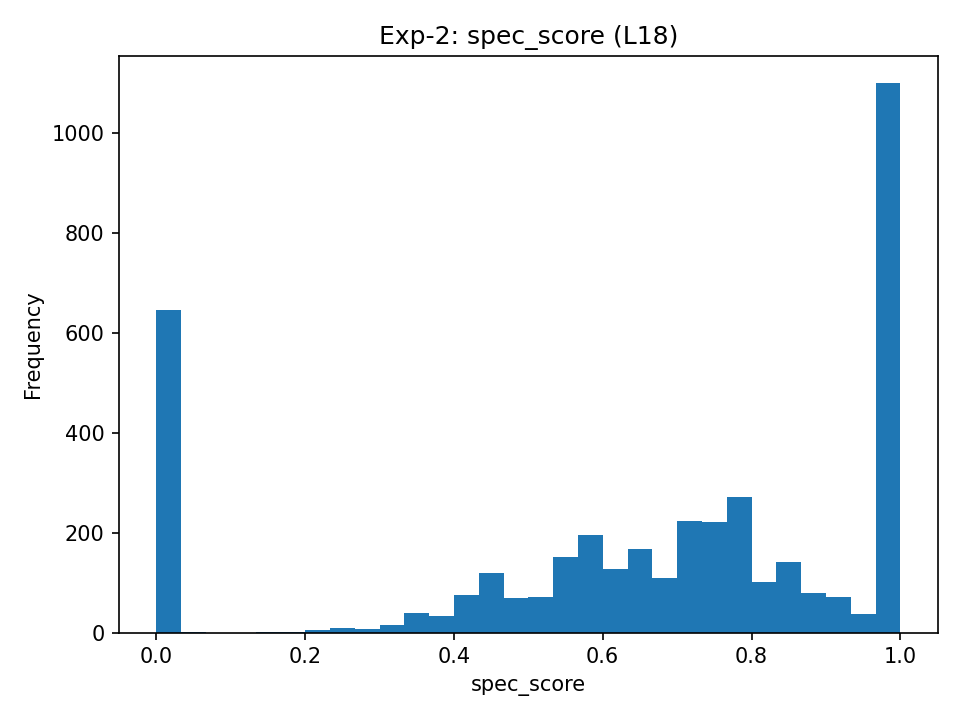

**artifacts/figures/exp2_L18_category_bar.png**

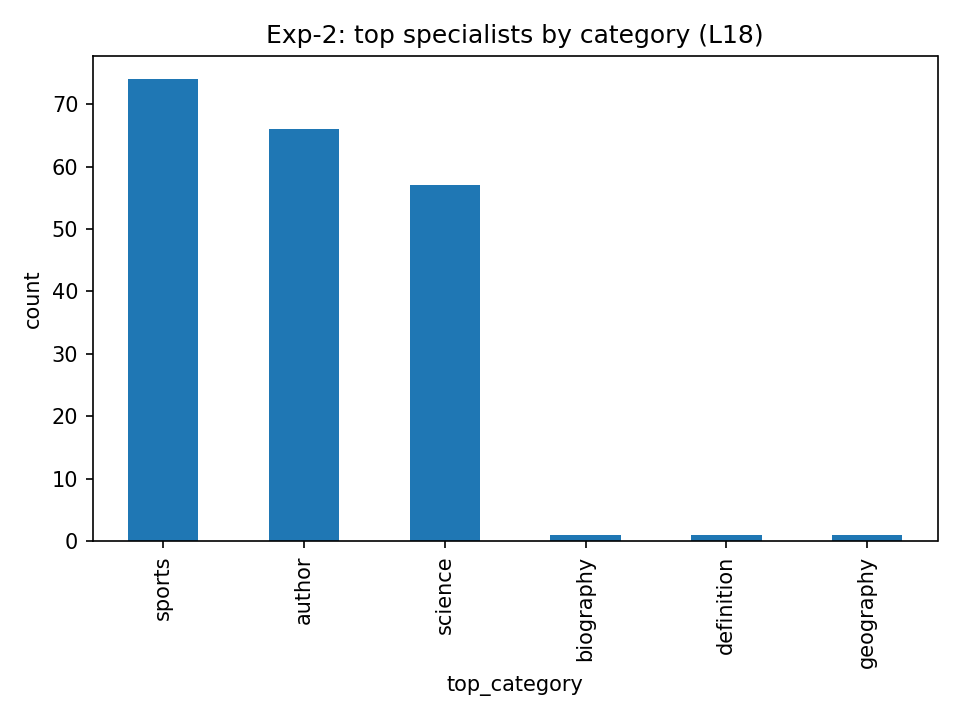

**artifacts/figures/exp2_L18_spec_vs_activity.png**

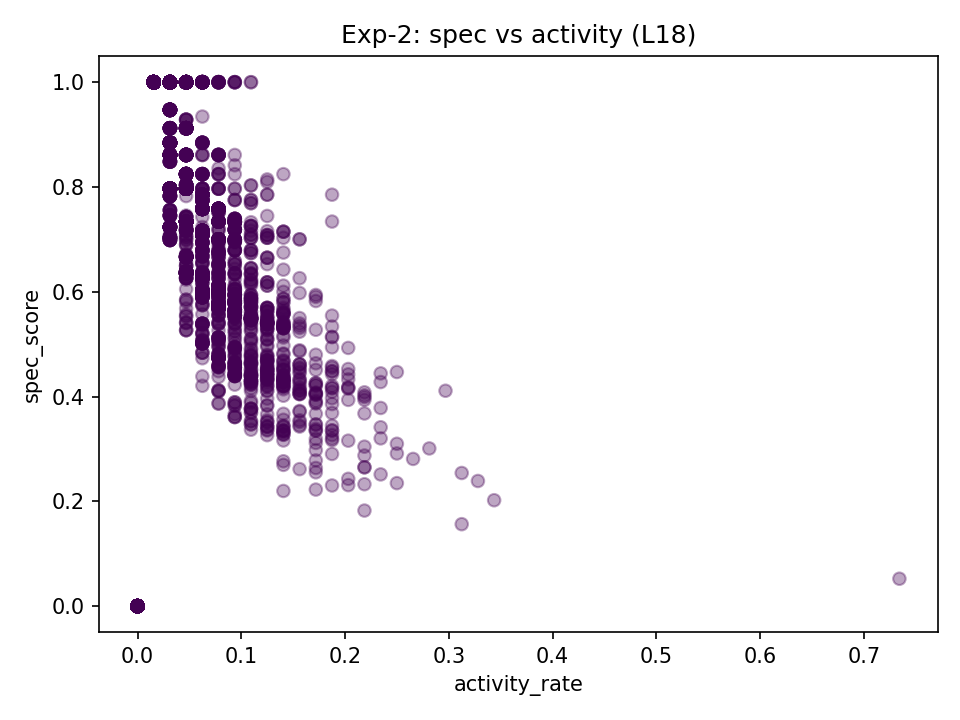

In [38]:
# Change L to whichever layer you want to review
L = 18
show_exp2_layer(L)


**artifacts/figures/exp3_L18_top_doc_frac_hist.png**

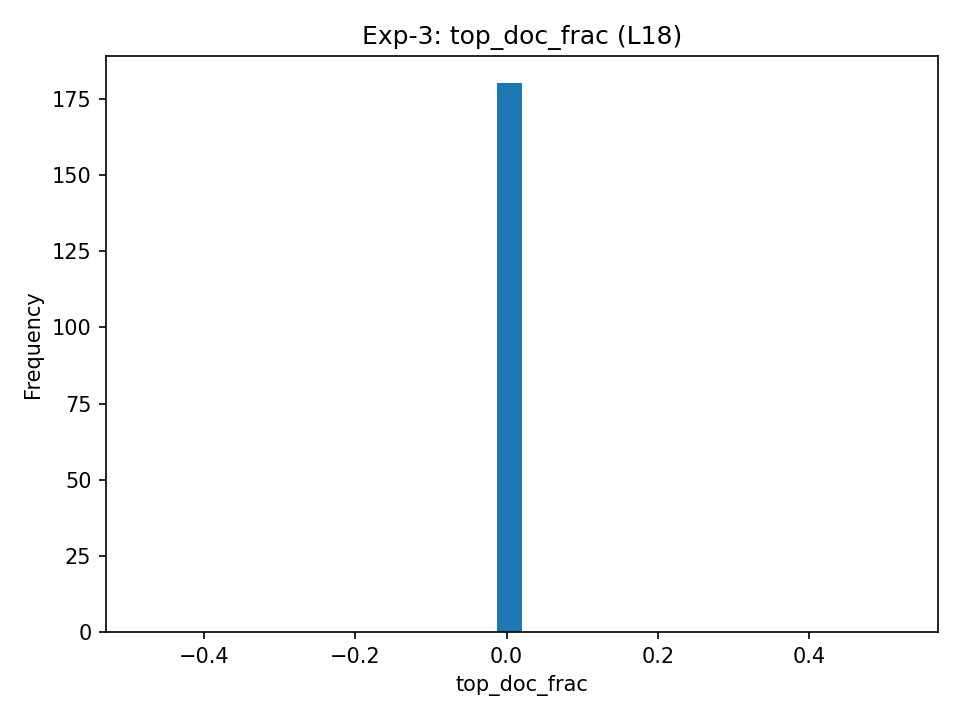

**artifacts/figures/exp3_L18_entropy_vs_active.png**

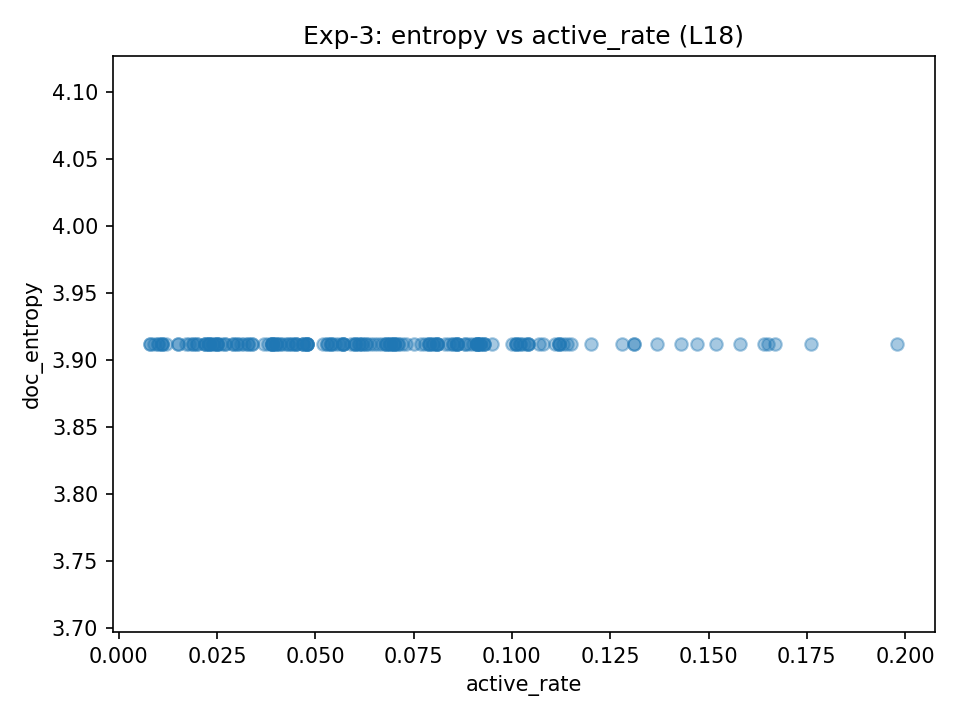

**artifacts/figures/exp3_L18_N15_topdocs.png**

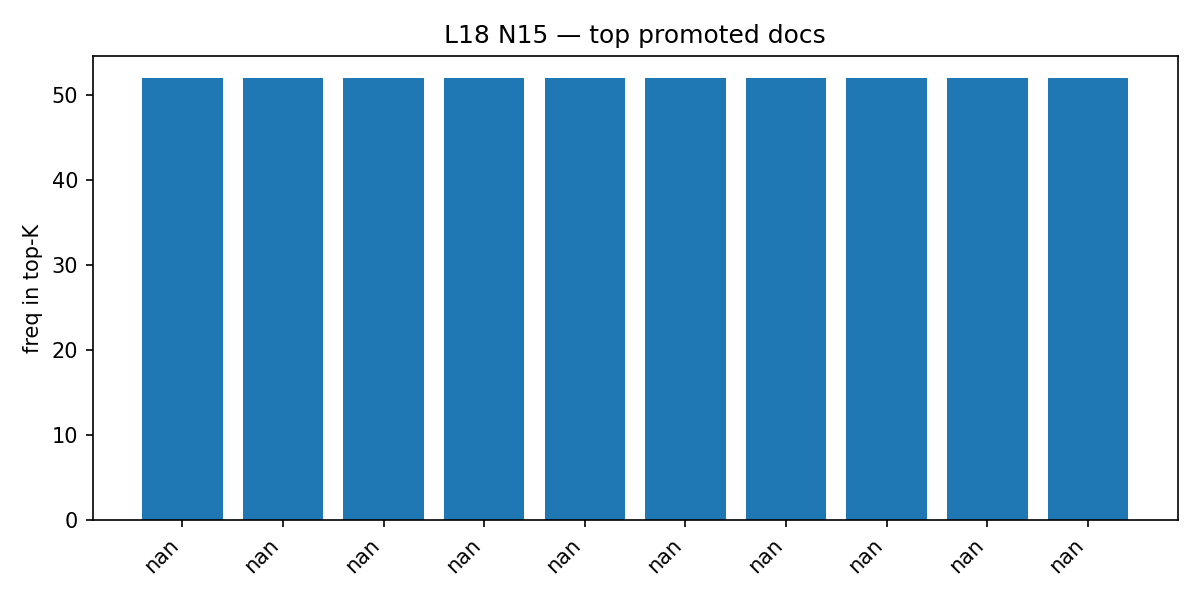

**artifacts/figures/exp3_L18_N33_topdocs.png**

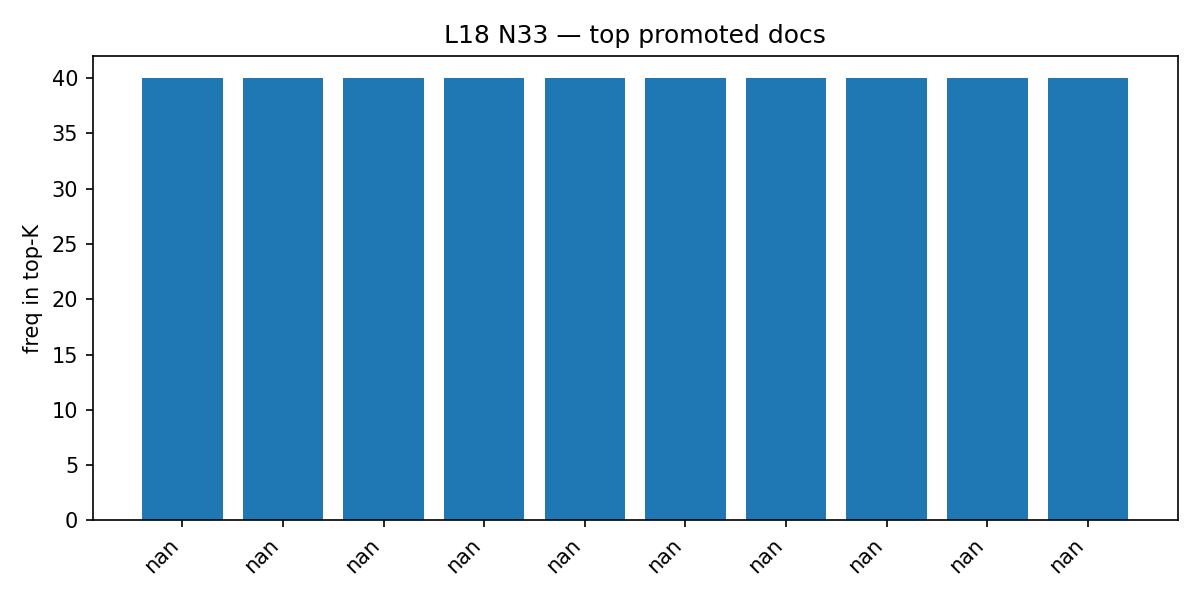

**artifacts/figures/exp3_L18_N46_topdocs.png**

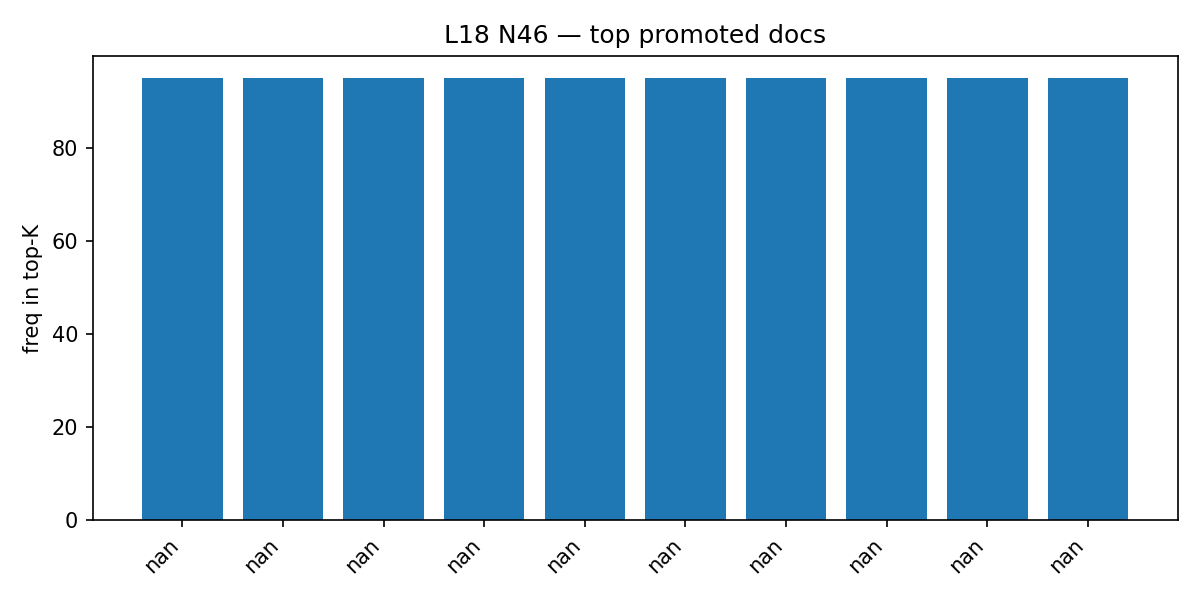

In [44]:
L = 18
show_exp3_layer(L, topdocs_max=3)  # increase/decrease how many neuron panels to show


In [45]:
def exp3_summ(layer):
    d = df3[df3["layer"]==layer]
    if d.empty: 
        print(f"L{layer}: no rows"); 
        return
    q = d["top_doc_frac"].quantile([0.5, 0.9, 0.95]).to_dict()
    e = d["doc_entropy"].quantile([0.5, 0.1]).to_dict()  # median, lower tail
    corr = d[["active_rate","doc_entropy"]].corr().iloc[0,1]
    conc = ((d["top_doc_frac"]>=0.04) | (d["doc_entropy"]<=3.2)).sum()
    print(f"L{layer}: n={len(d)}  top_doc_frac median={q[0.5]:.3f}  p90={q[0.9]:.3f}  p95={q[0.95]:.3f}")
    print(f"       doc_entropy median={e[0.5]:.2f}  p10={e[0.1]:.2f}  corr(active,entropy)={corr:.2f}  concentrated={conc}")
for L in [23,18]:
    exp3_summ(L)


L23: n=38  top_doc_frac median=0.020  p90=0.020  p95=0.024
       doc_entropy median=3.91  p10=3.91  corr(active,entropy)=-0.16  concentrated=2
L18: n=180  top_doc_frac median=0.020  p90=0.020  p95=0.020
       doc_entropy median=3.91  p10=3.91  corr(active,entropy)=nan  concentrated=0


In [46]:
# pick best L23 neuron by top_doc_frac (or lowest entropy)
best = df3[df3["layer"]==23].sort_values(["top_doc_frac","doc_entropy"], ascending=[False, True]).head(1)
display(best[["layer","neuron_id","active_rate","top_doc_frac","doc_entropy"]])

nid = int(best["neuron_id"].iloc[0])
perq = REPO_ROOT / f"logit_lens/results/exp1/L23/neuron_{nid:06d}_perquery.csv"
if perq.exists():
    d = pd.read_csv(perq)
    keep = [c for c in ["q_idx","query","a_j","active","top1_doc_token_id","top1_score","gt_doc_token_id","gt_rank","hit@1"] if c in d.columns]
    display(d.head(12)[keep])
else:
    print("perquery not found:", perq)


,layer,neuron_id,active_rate,top_doc_frac,doc_entropy
311,23,827,0.015625,0.05,2.995732


,q_idx,query,a_j,active,top1_doc_token_id,top1_score,gt_doc_token_id,gt_rank,hit@1
0,0,who sings every light in the house is on,0.0,inactive,NaN,NaN,NaN,NaN,0
1,1,the combination of biotic and abiotic factors ...,0.0,inactive,NaN,NaN,NaN,NaN,0
2,2,what is the name of the skin between your nost...,0.0,inactive,NaN,NaN,NaN,NaN,0
3,3,when did the smoking ban in public places start,0.0,inactive,NaN,NaN,NaN,NaN,0
4,4,what is the meaning of the greek word metanoia,0.0,inactive,NaN,NaN,NaN,NaN,0
5,5,who named all the animals in the world,0.0,inactive,NaN,NaN,NaN,NaN,0
6,6,who was the original host of jokers wild,0.0,inactive,NaN,NaN,NaN,NaN,0
7,7,how many gold medals did australia win in the ...,0.0,inactive,NaN,NaN,NaN,NaN,0
8,8,where did the name kaiser permanente come from,0.0,inactive,NaN,NaN,NaN,NaN,0
9,9,when did the egyptian ruler of lower nubia dec...,0.0,inactive,NaN,NaN,NaN,NaN,0


In [48]:
# Cross-layer summary for L18–23: medians/upper tails and specialist counts
layers = [18,19,20,21,22,23]

rows = []
# Exp-2: spec/activity (per neuron)
for L in layers:
    spec_path = REPO_ROOT / f"artifacts/exp2/neuron_specialization_L{L}.csv"
    if not spec_path.exists(): 
        continue
    d = pd.read_csv(spec_path)
    s = {
        "layer": L,
        "n_neurons": len(d),
        "spec_median": d["spec_score"].median(),
        "spec_p90": d["spec_score"].quantile(0.9),
        "activity_median": d["activity_rate"].median(),
        "activity_p90": d["activity_rate"].quantile(0.9),
        "n_specialists_spec>=0.6&act<=0.05": int(((d["spec_score"]>=0.6)&(d["activity_rate"]<=0.05)).sum()),
    }
    rows.append(s)
df_exp2_summary = pd.DataFrame(rows).sort_values("layer")

# Exp-3: doc concentration (for same layers)
rows = []
for L in layers:
    d = df3[df3["layer"]==L]
    if d.empty: 
        continue
    s = {
        "layer": L,
        "n_neurons_exp3": len(d),
        "top_doc_frac_median": d["top_doc_frac"].median(),
        "top_doc_frac_p95": d["top_doc_frac"].quantile(0.95),
        "doc_entropy_median": d["doc_entropy"].median(),
        "n_concentrated(top_frac>=0.04 or H<=3.2)": int(((d["top_doc_frac"]>=0.04)|(d["doc_entropy"]<=3.2)).sum()),
    }
    rows.append(s)
df_exp3_summary = pd.DataFrame(rows).sort_values("layer")

display(df_exp2_summary); display(df_exp3_summary)

(df_exp2_summary.to_csv(REPO_ROOT/"artifacts/summary_exp2_layers.csv", index=False))
(df_exp3_summary.to_csv(REPO_ROOT/"artifacts/summary_exp3_layers.csv", index=False))
print("[OK] wrote artifacts/summary_exp2_layers.csv & artifacts/summary_exp3_layers.csv")


,layer,n_neurons,spec_median,spec_p90,activity_median,activity_p90,n_specialists_spec>=0.6&act<=0.05
0,18,4096,0.723565,1.000000,0.046875,0.109375,1930
1,19,4096,0.190322,0.472493,0.042000,0.099000,235
2,20,4096,0.190769,0.473729,0.042000,0.098000,215
3,21,4096,0.189765,0.479085,0.042000,0.097000,228
4,22,4096,0.188727,0.523594,0.040000,0.102000,274
5,23,4096,0.208116,0.717040,0.032000,0.117000,563


,layer,n_neurons_exp3,top_doc_frac_median,top_doc_frac_p95,doc_entropy_median,n_concentrated(top_frac>=0.04 or H<=3.2)
0,18,180,0.02,0.0200,3.912023,0
1,19,28,0.02,0.0200,3.912023,0
2,20,32,0.02,0.0200,3.912023,0
3,21,39,0.02,0.0200,3.912023,0
4,22,26,0.02,0.0200,3.912023,0
5,23,38,0.02,0.0245,3.912023,2


[OK] wrote artifacts/summary_exp2_layers.csv & artifacts/summary_exp3_layers.csv


In [49]:
# Build per-layer category lift bars from top_specialists (if present)
out = []
for L in layers:
    top_path = REPO_ROOT / f"artifacts/exp2/top_specialists_L{L}.csv"
    if not top_path.exists(): 
        continue
    d = pd.read_csv(top_path)
    if not {"top_category","top_cat_lift"}.issubset(d.columns):
        continue
    g = d.groupby("top_category")["top_cat_lift"].mean().sort_values(ascending=False)
    out.append((L, g))
    # plot
    g.head(8).plot(kind="bar", title=f"Exp-2: mean lift by category (L{L})")
    savefig(FIG_DIR / f"exp2_L{L}_category_lift_bar.png")
print("[OK] category-lift bars written (where data present)")


[figure] artifacts/figures/exp2_L18_category_lift_bar.png
[figure] artifacts/figures/exp2_L19_category_lift_bar.png
[figure] artifacts/figures/exp2_L20_category_lift_bar.png
[figure] artifacts/figures/exp2_L21_category_lift_bar.png
[figure] artifacts/figures/exp2_L22_category_lift_bar.png
[figure] artifacts/figures/exp2_L23_category_lift_bar.png
[OK] category-lift bars written (where data present)


In [50]:
# If df1 has active_rate per neuron summaries:
if "active_rate" in df1.columns:
    plt.figure()
    data = [df1[df1["layer"]==L]["active_rate"].dropna().values for L in sorted(df1["layer"].unique())]
    plt.boxplot(data, labels=sorted(df1["layer"].unique()))
    plt.xlabel("layer"); plt.ylabel("active_rate"); plt.title("Exp-1: neuron active_rate by layer")
    savefig(FIG_DIR / "exp1_active_rate_boxplot.png")
    print("[figure] artifacts/figures/exp1_active_rate_boxplot.png")
else:
    print("[skip] df1 missing active_rate")


[figure] artifacts/figures/exp1_active_rate_boxplot.png
[figure] artifacts/figures/exp1_active_rate_boxplot.png


**artifacts/figures/exp1_L23_active_rate_hist.png**

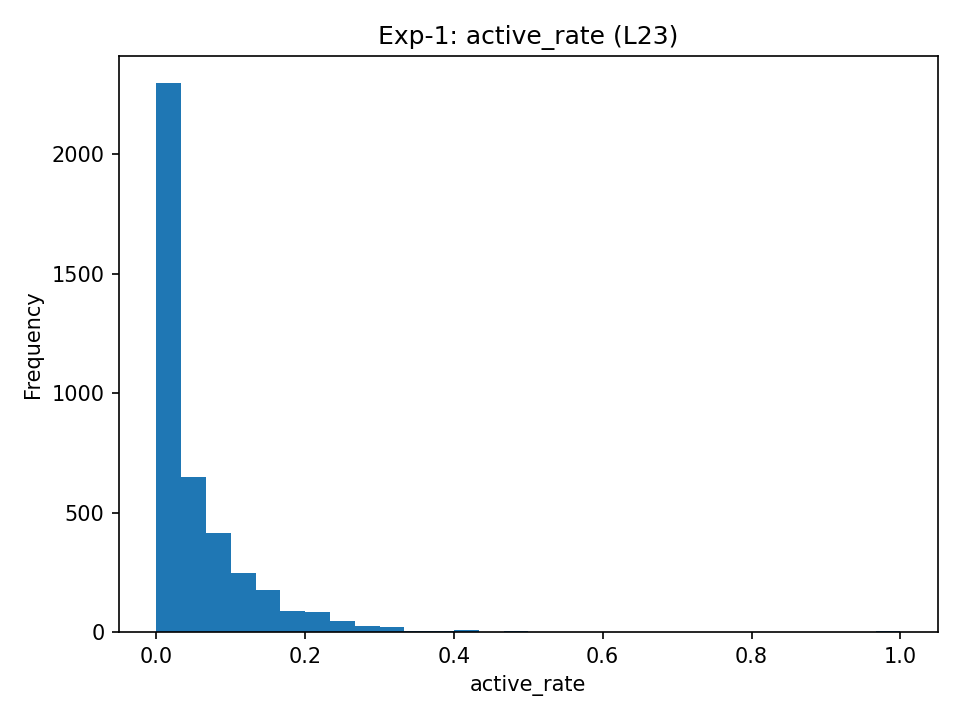

In [57]:
L = 23
show_exp1_layer(L)
